In [1]:
#importing required python classes and packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.models import Sequential, load_model, Model
import pickle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.layers import AveragePooling2D
import keras
from sklearn.model_selection import train_test_split
from keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics 

Using TensorFlow backend.
c:\users\ps838\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\ps838\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\ps838\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#define and load class labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())   
print("Dataset Class Labels : "+str(labels))     

Dataset Class Labels : ['Melanoma', 'NotMelanoma']


In [3]:
#define function to get class label of given image
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#load dataset image and process them
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else: #if images not process then read and process image pixels
    for root, dirs, directory in os.walk(path):#connect to dataset folder
        for j in range(len(directory)):#loop all images from dataset folder
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read images
                img = cv2.resize(img, (32, 32))#resize image
                X.append(img) #add image pixels to X array
                label = getLabel(name)#get image label id
                Y.append(label)#add image label                
    X = np.asarray(X)#convert array as numpy array
    Y = np.asarray(Y)
    np.save('model/X.txt',X)#save process images and labels
    np.save('model/Y.txt',Y)
print("Dataset images loaded")
print("Total images found in dataset : "+str(X.shape[0]))
print()

Dataset images loaded
Total images found in dataset : 10682



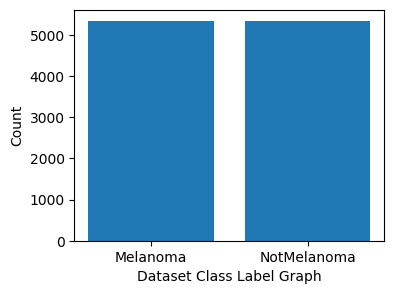

In [5]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.show()

(-0.5, 31.5, 31.5, -0.5)

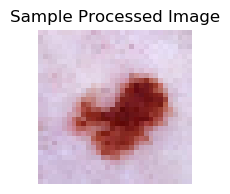

In [6]:
#display processed sample image
img = X[100]
plt.figure(figsize =(2, 2)) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Processed Image")
plt.axis("off")

In [7]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 9613
20% image used to train algorithms : 1069


In [8]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [9]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(10, 3))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_fpr, ns_tpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()




DenseNet121 on White Skin Accuracy  : 98.31618334892423
DenseNet121 on White Skin Precision : 98.31121052373652
DenseNet121 on White Skin Recall    : 98.33151233724847
DenseNet121 on White Skin FSCORE    : 98.31585175434296


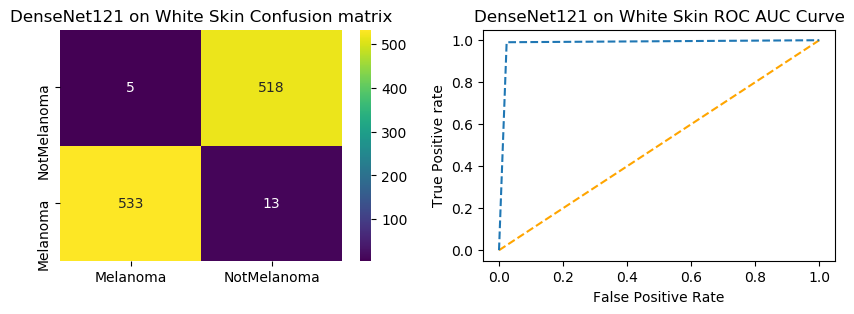

In [10]:
#define, train and load densenet model 
densenet = DenseNet121(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), include_top=False, weights='imagenet')
for layer in densenet.layers:
    layer.trainable = False
headModel = densenet.output
headModel = AveragePooling2D(pool_size=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(y_train.shape[1], activation="softmax")(headModel)
densenet_model = Model(inputs=densenet.input, outputs=headModel)
densenet_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/densenet_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/densenet_weights.hdf5', verbose = 1, save_best_only = True)
    hist = densenet_model.fit(X_train, y_train, batch_size = 64, epochs = 20, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/densenet_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    densenet_model.load_weights("model/densenet_weights.hdf5")
#perform prediction on white images test data   
predict = densenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("DenseNet121 on White Skin", y_test1, predict)

DenseNet121 on Dark Skin Accuracy  : 99.0
DenseNet121 on Dark Skin Precision : 99.01960784313727
DenseNet121 on Dark Skin Recall    : 99.0
DenseNet121 on Dark Skin FSCORE    : 98.999899989999


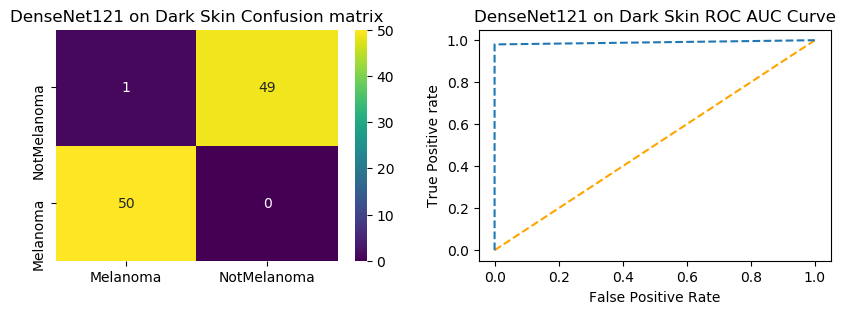

In [11]:
#load dark skin test data
dark_X = np.load('model/black_test.txt.npy')
dark_Y = np.load('model/black_label.txt.npy')
dark_X = dark_X.astype('float32')
dark_X = dark_X/255
indices = np.arange(dark_X.shape[0])
np.random.shuffle(indices)
dark_X = dark_X[indices]
dark_Y = dark_Y[indices]
dark_Y = to_categorical(dark_Y)
#perform prediction on white images test data   
predict = densenet_model.predict(dark_X)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(dark_Y, axis=1)
calculateMetrics("DenseNet121 on Dark Skin", y_test1, predict)

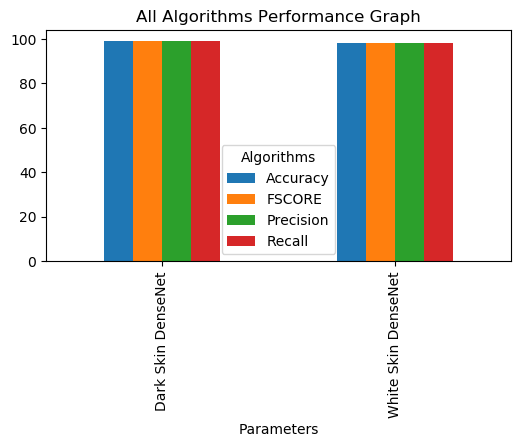

In [12]:
#comparison graph between all algorithms
import pandas as pd
df = pd.DataFrame([['White Skin DenseNet','Accuracy',accuracy[0]],['White Skin DenseNet','Precision',precision[0]],['White Skin DenseNet','Recall',recall[0]],['White Skin DenseNet','FSCORE',fscore[0]],
                   ['Dark Skin DenseNet','Accuracy',accuracy[1]],['Dark Skin DenseNet','Precision',precision[1]],['Dark Skin DenseNet','Recall',recall[1]],['Dark Skin DenseNet','FSCORE',fscore[1]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(6, 3))
plt.title("All Algorithms Performance Graph")
plt.show()

In [13]:
#display all algorithm performnace
algorithms = ['DenseNet121 White Skin', 'DenseNet121 Dark Skin']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data   

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,DenseNet121 White Skin,98.316183,98.311211,98.331512,98.315852
1,DenseNet121 Dark Skin,99.000000,99.019608,99.000000,98.999900


In [14]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = densenet_model.predict(img)#now predict dog breed
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (600,400))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    plt.imshow(img)

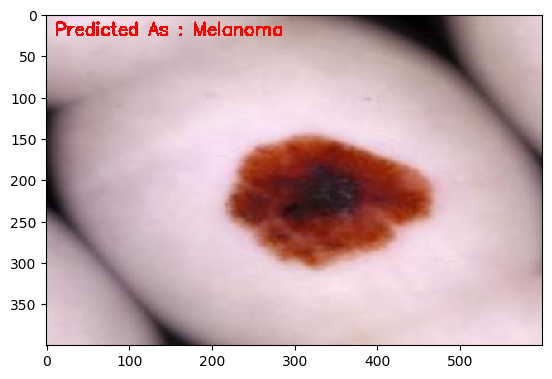

In [15]:
#call this function with test image to predict skin cancer
predict("testImages/1.jpeg")

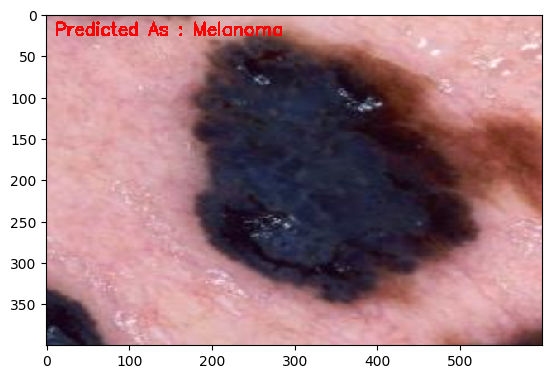

In [16]:
#call this function with test image to predict skin cancer
predict("testImages/5.jpeg")

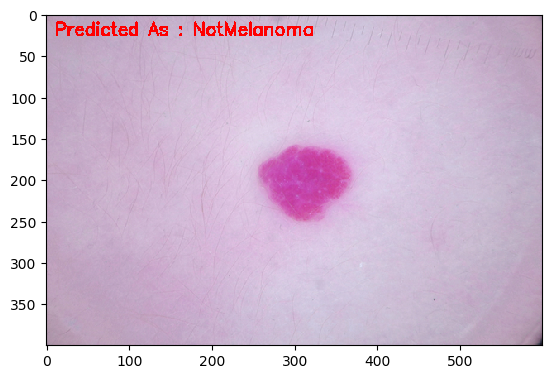

In [17]:
#call this function with test image to predict skin cancer
predict("testImages/4.jpg")

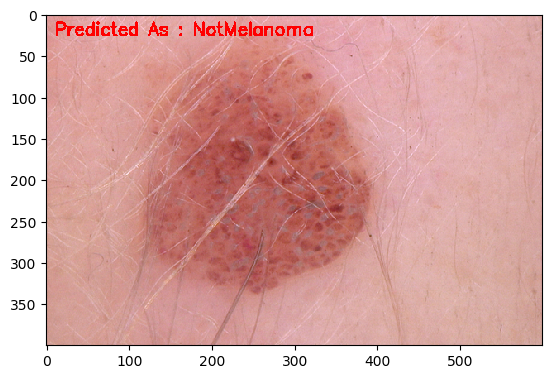

In [18]:
#call this function with test image to predict skin cancer
predict("testImages/2.jpg")

In [ ]:
predict("testImages/3.jpg")